# What data did we use?

Samples: the PDF on a grid (rmin = 1.5, rmax = 30.0, rstep = $pi$ / 23.0). It is a 1D vector of shape `(209,)`.

The PDFs are simulated from 10,000 combination of the structures randomly choosen from about 2000 structures. For each combination, the simulation is done usng 11 different mole fractions `[[1.0, 0.0], [0.0, 1.0], [0.95, 0.05], [0.05, 0.95], [0.2, 0.8], [0.8, 0.2], [0.3, 0.7], [0.7, 0.3], [0.4, 0.6], [0.6, 0.4], [0.5, 0.5]]`. In total, there are 110,000 PDFs.

Labels: Whether it is a single phase or mulitple phases. The single phase is defined as the minor phase < 5%.

Datasets: 80% train, 10% validation, 10% test. The data set is shuffled when splitting and the train data set is shuffled in every training epoch.

# What models did we use?

We tested three models:

1. Logistric regression (LR)

2. Convolutional neural network + Full connected layers (CNN-FC)

Please look at section 10, 11, 12, 13, 14 for the details.

# How do we optimize the model

Loss: categorical cross entropy

Metric: cosine similarity

# How good is our model?

In [1]:
# choose the tensorflow log level
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import tensorflow as tf

In [11]:
FEATURES_FILE = "./data/tensors/features.npy"  # path to the file of the feature tensor
LABELS_FILE = "./data/tensors/labels.npy"  # path to the file of the feature tensor
BATCH_SIZE = 1024 * 8  # number of points to test
MODEL_FILES = [
    "./data/models/lr_20210914-171635/",
    "./data/models/cnn_2_20210914-172931/", 
    "./data/models/cnn_2_20210914-182924/",
    "./data/models/cnn_4_20210914-200148/",
    "./data/models/cnn_5_20210914-210742/"
]
MODEL_NAMES = [
    "1_LR", 
    "2_CNN-FC-2-1",
    "3_CNN-FC-2-2",
    "4_CNH-FC-4",
    "5_CNN-FC-5"
]
METRICS = [0.7406, 0.8858, 0.8665, 0.7729, 0.8471]

## Scalar metrics

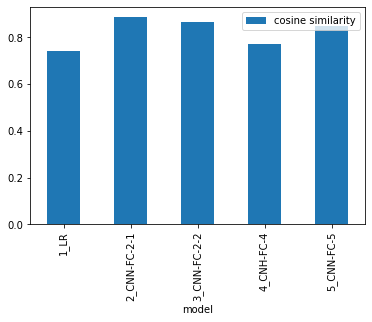

In [12]:
df = pd.DataFrame(
    {"cosine similarity": METRICS},
    index=pd.Index(MODEL_NAMES, name="model")
)
df.plot.bar();

## Predict some random batch

In [5]:
def load_data():
    # load
    features, labels = np.load(FEATURES_FILE), np.load(LABELS_FILE)
    # shuffle
    n = features.shape[0]
    shuffled_idx = np.random.permutation(n)
    features, labels = features[shuffled_idx], labels[shuffled_idx]
    return tf.data.Dataset.from_tensor_slices((features, labels))

In [6]:
data = load_data()

In [13]:
def evulate_model(model, samples, labels):
    pred = model.predict(samples)
    ds = xr.Dataset(
        {
            "prediction": (["sample", "label"], pred),
            "expection": (["sample", "label"], labels)
        }, 
        coords={"label": ["mutliple", "single"]}
    )
    return ds

def evaludate_models(models, model_names, samples, labels):
    dss = []
    n = len(models)
    for i in range(n):
        ds = evulate_model(models[i], samples, labels)
        ds = ds.assign_coords({"model": model_names[i]}).expand_dims("model")
        dss.append(ds)
    return xr.merge(dss)

In [8]:
gen = data.batch(BATCH_SIZE).as_numpy_iterator()
test_samples, test_labels = next(gen)

In [9]:
models = list(map(tf.keras.models.load_model, MODEL_FILES))

In [14]:
eval_res = evaludate_models(
    models,
    MODEL_NAMES,
    test_samples,
    test_labels
)

In [17]:
def visualize(eval_res):
    facet = xr.plot.facetgrid.FacetGrid(eval_res, col="model", sharey=True, size=5)
    axes = facet.axes.flatten()
    m = axes.shape[0]
    for i in range(m):
        ax = axes[i]
        for j in range(2):
            eval_res["prediction"][i, :, j].plot.hist(bins=np.arange(0., 1.0001, 0.01), ax=ax)
            ax.set_title(eval_res["model"][i].item())
            ax.set_ylabel("number of samples")
            ax.legend(eval_res["label"].values)
    return

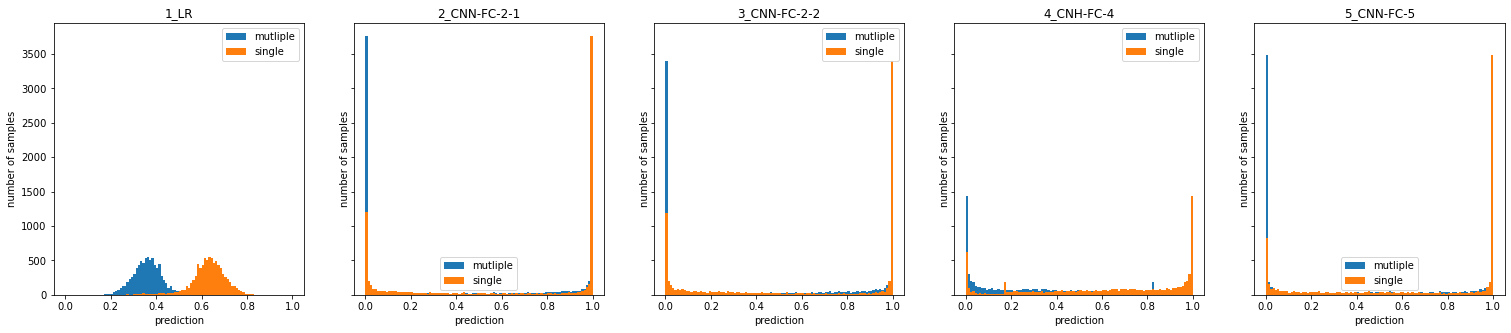

In [18]:
visualize(eval_res);

# Conlcusion

It looks that the CNN-FC model can predict most of the data correctly